In [1]:
DATA_PATH = '../data/Build_Project/'

In [2]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

# I. Wrangle Data

In [3]:
#Read in the data
submission_format, test_set_features, training_set_features, training_set_labels = pd.read_csv(
    DATA_PATH+'submission_format.csv'),pd.read_csv(
    DATA_PATH+'test_set_features.csv'),pd.read_csv(
    DATA_PATH+'training_set_features.csv'),pd.read_csv(
    DATA_PATH+'training_set_labels.csv')

drop_col = 'respondent_id'

training_set_features.drop(columns = drop_col, inplace = True)
test_set_features.drop(columns = drop_col, inplace = True)

In [4]:
training_set_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


# II. Split Data

In [5]:
#Split the data
target1 = 'h1n1_vaccine'
target2 = 'seasonal_vaccine'
y1= training_set_labels[target1]
y2= training_set_labels[target2]
X = training_set_features

# II. Establish Baseline

In [6]:
#Print AUROC score for imbalanced H1N1 dataset
print('Baseline AUROC score is: %.3f'% roc_auc_score(y1, [0]*len(y1)))

#Print baseline accuracy for balanced Seasonal Flu dataset
print('Baseline Accuracy Seasonal Flu Vaccine: %.3f'% y2.value_counts(normalize=True).max())

Baseline AUROC score is: 0.500
Baseline Accuracy Seasonal Flu Vaccine: 0.534


# IV. Build Models

### A. H1N1 Vaccine Models

In [7]:
#H1N1 Vaccine random forest model
h1_model = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(max_depth = 23,
                           max_features = 'sqrt',
                           min_samples_leaf = 2,
                           min_samples_split = 18,
                           n_estimators = 75,
                           random_state=42,
                           n_jobs=-1)    
)

h1_model.fit(X, y1);

In [8]:
#Building model file for app
# from joblib import dump
# dump(h1_model, 'pipeline.joblib', compress = True)

In [9]:
#H1N1 Vaccine grandient boosting model
h1_gb_model = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='median'), 
    GradientBoostingClassifier(learning_rate = 0.1,
                               warm_start = False,
                              n_estimators = 150,
                              random_state = 42)    
)

h1_gb_model.fit(X, y1);

In [10]:
#H1N1 Vaccine xgboost model
h1_xgb_model = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='mean'), 
    XGBClassifier(random_state = 42,
                 n_jobs = -1,
                 eval_metric = 'auc')
)

h1_xgb_model.fit(X, y1);

### B. Seasonal Flu Vaccine Model

In [11]:
#Add H1N1 predictions to Seasonal Flu features
X_sf = X.copy()
X_sf['h1_prediction'] = h1_xgb_model.predict(X)

#Seasonal Flu Vaccine Model
sf_model = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(max_depth = 15,
                           max_features = 'sqrt',
                           min_samples_leaf = 4,
                           min_samples_split = 26,
                           n_estimators = 100,
                           random_state=42,
                           n_jobs=-1)   
)

sf_model.fit(X_sf, y2);

In [12]:
#Seasonal Flu Vaccine grandient boosting model
sf_gb_model = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='median'), 
    GradientBoostingClassifier(learning_rate = 0.1,
                              n_estimators = 150,
                              random_state = 42)    
)

sf_gb_model.fit(X_sf, y2);

In [13]:
#Seasonal Flu Vaccine xgboost model
sf_xgb_model = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='mean'), 
    XGBClassifier(random_state = 42,
                 n_jobs = 10,
                 eval_metric = 'auc')   
)

sf_xgb_model.fit(X_sf, y2);

# V. Check Metrics

## A. H1N1 Model Metrics

### 1. H1N1 Cross-Validation/AUC scores

In [14]:
#H1N1 model cross-validation
cv_scores_h1 = cross_val_score(h1_model, X, y1, n_jobs=-1)
cv_scores_h1_gb = cross_val_score(h1_gb_model, X, y1, n_jobs=-1)
cv_scores_h1_xgb = cross_val_score(h1_xgb_model, X, y1, n_jobs=-1)

#Calculate AUROC scores
r1_auc = roc_auc_score(y1, [0]*len(y1))
h1_auc = roc_auc_score(y1, h1_model.predict(X))
h1_gb_auc = roc_auc_score(y1, h1_gb_model.predict(X))
h1_xgb_auc = roc_auc_score(y1, h1_xgb_model.predict(X))

#Print scores
#Random forest model CV scores
print('CV score RandomForestClassifier')
print(cv_scores_h1)
print('Mean CV accuracy score:', cv_scores_h1.mean())
print('STD CV accuracy score:', cv_scores_h1.std())
print()
#Gradient boosting model CV scores
print('CV score GradientBoostingClassifier')
print(cv_scores_h1_gb)
print('Mean CV accuracy score:', cv_scores_h1_gb.mean())
print('STD CV accuracy score:', cv_scores_h1_gb.std())
print()
#XGBoost model CV scores
print('CV score XGBoostClassifier')
print(cv_scores_h1_xgb)
print('Mean CV accuracy score:', cv_scores_h1_xgb.mean())
print('STD CV accuracy score:', cv_scores_h1_xgb.std())
print()
print('Baseline: AUROC = %.3f'% (r1_auc))
print('H1N1 Random Forest Model: AUROC = %.3f'% (h1_auc))
print('H1N1 Gradient Boosting Model: AUROC = %.3f'% (h1_gb_auc))
print('H1N1 XGBoost Model: AUROC = %.3f'% (h1_xgb_auc))

CV score RandomForestClassifier
[0.85754399 0.84949457 0.8537727  0.85957686 0.84853024]
Mean CV accuracy score: 0.853783672025376
STD CV accuracy score: 0.004328881662816459

CV score GradientBoostingClassifier
[0.84200674 0.83676526 0.84047931 0.84927916 0.83392623]
Mean CV accuracy score: 0.8404913397492788
STD CV accuracy score: 0.0052250690846803866

CV score XGBoostClassifier
[0.85117933 0.85043055 0.85283655 0.85639393 0.84291331]
Mean CV accuracy score: 0.850750735447147
STD CV accuracy score: 0.004425103792584894

Baseline: AUROC = 0.500
H1N1 Random Forest Model: AUROC = 0.779
H1N1 Gradient Boosting Model: AUROC = 0.710
H1N1 XGBoost Model: AUROC = 0.847


### 2. Plot ROC for H1N1 Model

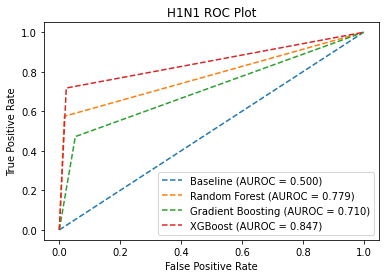

In [15]:
#Calculate ROC curve
r1_fpr, r1_tpr, _ = roc_curve(y1, [0]*len(y1))
h1_rf_fpr, h1_rf_tpr, _ = roc_curve(y1, h1_model.predict(X))
h1_gb_fpr, h1_gb_tpr, _ = roc_curve(y1, h1_gb_model.predict(X))
h1_xgb_fpr, h1_xgb_tpr, _ = roc_curve(y1, h1_xgb_model.predict(X))

#Plot ROC curve
plt.plot(r1_fpr,r1_tpr,
         linestyle='--',
         label = 'Baseline (AUROC = %.3f)' % r1_auc)

plt.plot(h1_rf_fpr,h1_rf_tpr,
         linestyle='--',
         label = 'Random Forest (AUROC = %.3f)' % h1_auc)

plt.plot(h1_gb_fpr,h1_gb_tpr,
         linestyle='--',
         label = 'Gradient Boosting (AUROC = %.3f)' % h1_gb_auc)

plt.plot(h1_xgb_fpr,h1_xgb_tpr,
         linestyle='--',
         label = 'XGBoost (AUROC = %.3f)' % h1_xgb_auc)

#Title
plt.title('H1N1 ROC Plot')
#Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#Show legend
plt.legend()
#Show plot
plt.show()

## B. Seasonal Flu Model Metrics

### 1. Seasonal Flu Cross-Validation/AUC scores

In [16]:
#Seasonal flu model cross-validation
cv_scores_sf = cross_val_score(sf_model, X_sf, y2, n_jobs=-1)
cv_scores_sf_gb = cross_val_score(sf_gb_model, X_sf, y2, n_jobs=-1)
cv_scores_sf_xgb = cross_val_score(sf_xgb_model, X_sf, y2, n_jobs=-1)

#Calculate AUROC scores
r2_auc = roc_auc_score(y2, [0]*len(y2))
sf_auc = roc_auc_score(y2, sf_model.predict(X_sf))
sf_gb_auc = roc_auc_score(y2, sf_gb_model.predict(X_sf))
sf_xgb_auc = roc_auc_score(y2, sf_xgb_model.predict(X_sf))



#Print Scores
#Random forest model CV scores
print('CV score RandomForestClassifier')
print(cv_scores_sf)
print('Mean CV accuracy score:', cv_scores_sf.mean())
print('STD CV accuracy score:', cv_scores_sf.std())
print()
print('Baseline: AUROC = %.3f'% (r2_auc))
print('Seasonal Flu Model: AUROC = %.3f'% (sf_auc))
#Gradient boosting model CV scores
print('CV score GradientBoostingClassifier')
print(cv_scores_sf_gb)
print('Mean CV accuracy score:', cv_scores_sf_gb.mean())
print('STD CV accuracy score:', cv_scores_sf_gb.std())
print()
#XGBoost model CV scores
print('CV score XGBoostClassifier')
print(cv_scores_sf_xgb)
print('Mean CV accuracy score:', cv_scores_sf_xgb.mean())
print('STD CV accuracy score:', cv_scores_sf_xgb.std())
print()
print('Baseline: AUROC = %.3f'% (r2_auc))
print('Seasonal Flu Random Forest Model: AUROC = %.3f'% (sf_auc))
print('Seasonal Flu Gradient Boosting Model: AUROC = %.3f'% (sf_gb_auc))
print('Seasonal Flu XGBoost Model: AUROC = %.3f'% (sf_xgb_auc))

CV score RandomForestClassifier
[0.78734556 0.79314863 0.79011421 0.79217375 0.78917806]
Mean CV accuracy score: 0.7903920429059379
STD CV accuracy score: 0.002078714175499289

Baseline: AUROC = 0.500
Seasonal Flu Model: AUROC = 0.838
CV score GradientBoostingClassifier
[0.79520779 0.79876451 0.79423329 0.80022468 0.79385883]
Mean CV accuracy score: 0.7964578179256685
STD CV accuracy score: 0.002560308441474879

CV score XGBoostClassifier
[0.7856608  0.78154249 0.7833739  0.79105037 0.78374836]
Mean CV accuracy score: 0.785075184299021
STD CV accuracy score: 0.003261302308547968

Baseline: AUROC = 0.500
Seasonal Flu Random Forest Model: AUROC = 0.838
Seasonal Flu Gradient Boosting Model: AUROC = 0.800
Seasonal Flu XGBoost Model: AUROC = 0.881


### 2. Plot ROC for Seasonal Flu Model

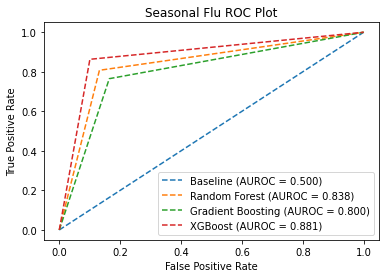

In [17]:
#Calculate ROC curve
r2_fpr, r2_tpr, _ = roc_curve(y1, [0]*len(y1))
sf_rf_fpr, sf_rf_tpr, _ = roc_curve(y2, sf_model.predict(X_sf))
sf_gb_fpr, sf_gb_tpr, _ = roc_curve(y2, sf_gb_model.predict(X_sf))
sf_xgb_fpr, sf_xgb_tpr, _ = roc_curve(y2, sf_xgb_model.predict(X_sf))

#Plot ROC curve
plt.plot(r2_fpr,r2_tpr,
         linestyle='--',
         label = 'Baseline (AUROC = %.3f)' % r2_auc)

plt.plot(sf_rf_fpr,sf_rf_tpr,
         linestyle='--',
         label = 'Random Forest (AUROC = %.3f)' % sf_auc)

plt.plot(sf_gb_fpr,sf_gb_tpr,
         linestyle='--',
         label = 'Gradient Boosting (AUROC = %.3f)' % sf_gb_auc)

plt.plot(sf_xgb_fpr,sf_xgb_tpr,
         linestyle='--',
         label = 'XGBoost (AUROC = %.3f)' % sf_xgb_auc)

#Title
plt.title('Seasonal Flu ROC Plot')
#Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#Show legend
plt.legend()
#Show plot
plt.show()

# VI. Permutate Importances

## A. H1N1 Permutation Importances

In [18]:
#Calculate H1N1 model permutation importances
perm_imp_h1 = permutation_importance(h1_model,
                                 X,
                                 y1)

perm_imp_h1['importances_mean']

array([0.00576628, 0.00784813, 0.00111581, 0.00162504, 0.00089115,
       0.00083873, 0.00194706, 0.00193957, 0.0022466 , 0.05543116,
       0.0132924 , 0.00458307, 0.00190212, 0.00598345, 0.04777774,
       0.02862171, 0.03663459, 0.00672483, 0.01380163, 0.01429588,
       0.00446325, 0.00754858, 0.00544427, 0.00394653, 0.00305538,
       0.00390909, 0.00348223, 0.00234395, 0.00361703, 0.00774329,
       0.0031752 , 0.00253866, 0.00313027, 0.00983263, 0.00830494])

In [19]:
#Create dataframe using permutation importances
data_h1 = pd.DataFrame({'importances_mean': perm_imp_h1['importances_mean']}, index = X.columns)

data_h1['importances_mean'].sort_values().tail(10)

h1n1_knowledge                 0.007848
employment_occupation          0.008305
employment_industry            0.009833
doctor_recc_seasonal           0.013292
opinion_seas_vacc_effective    0.013802
opinion_seas_risk              0.014296
opinion_h1n1_vacc_effective    0.028622
opinion_h1n1_risk              0.036635
health_insurance               0.047778
doctor_recc_h1n1               0.055431
Name: importances_mean, dtype: float64

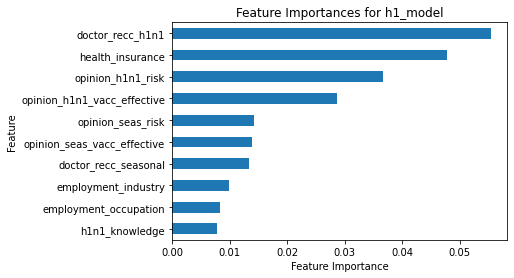

In [22]:
#Plot permutation importances
data_h1['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for h1_model');

## B. Seasonal Flu Permutation Importances

In [23]:
#Calculate Seasonal Flu model permutation importances
perm_imp_sf = permutation_importance(sf_model,
                                 X_sf,
                                 y2)

perm_imp_sf['importances_mean']

array([0.00688958, 0.00563897, 0.00018722, 0.00136294, 0.00056914,
       0.00172239, 0.00188715, 0.00197701, 0.00232898, 0.00834238,
       0.05782754, 0.00578126, 0.00089864, 0.00346726, 0.00559404,
       0.0054892 , 0.00974276, 0.00521212, 0.06154941, 0.06238065,
       0.01192946, 0.03942787, 0.00589359, 0.00521212, 0.00193208,
       0.00432096, 0.00214925, 0.00492755, 0.00518216, 0.00607331,
       0.00300296, 0.00244131, 0.00566144, 0.01181713, 0.00821507,
       0.03166211])

In [24]:
#Create dataframe using permutation importances
data_sf = pd.DataFrame({'importances_mean': perm_imp_sf['importances_mean']}, index = X_sf.columns)

data_sf['importances_mean'].sort_values().tail(10)

employment_occupation          0.008215
doctor_recc_h1n1               0.008342
opinion_h1n1_risk              0.009743
employment_industry            0.011817
opinion_seas_sick_from_vacc    0.011929
h1_prediction                  0.031662
age_group                      0.039428
doctor_recc_seasonal           0.057828
opinion_seas_vacc_effective    0.061549
opinion_seas_risk              0.062381
Name: importances_mean, dtype: float64

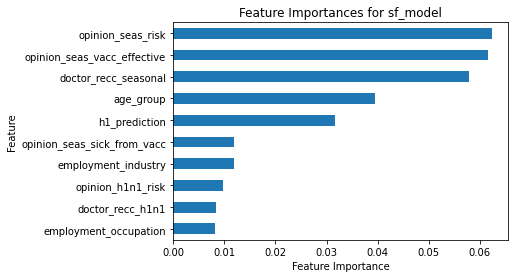

In [25]:
#Plot permutation importances
data_sf['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for sf_model');

# VII. Create Submission

In [26]:
#Arrange predictions

#H1N1 Vaccine Submission
submission_array1 = h1_xgb_model.predict_proba(test_set_features)
submission1 = pd.DataFrame(submission_array1[:, 1])
submission1.columns = ['h1n1_vaccine']

#Seasonal Flu Vaccine Submission
test_set_features_sf = test_set_features.copy()
test_set_features_sf['h1_prediction'] = h1_xgb_model.predict(test_set_features_sf)
submission_array2 = sf_xgb_model.predict_proba(test_set_features_sf)
submission2 = pd.DataFrame(submission_array2[:, 1])
submission2.columns = ['seasonal_vaccine']

#Format ID's
submission_id = pd.DataFrame(submission_format['respondent_id'])
submission_id

#Join DataFrames
final_xgb_submission = pd.concat([submission_id, submission1, submission2], axis=1)
final_xgb_submission.set_index('respondent_id', inplace =True)

In [27]:
#Create final submission
# from IPython.display import FileLink

# final_xgb_submission.to_csv('final_xgb_submission.csv')

# FileLink('final_xgb_submission.csv')

c:\Users\jalir\Documents\Github\vaccine-prediction-model\notebooks\final_xgb_submission.csv